# Reconstructed Samples

This notebook illustrates the reconstruced samples by LOMMA, as presented at the Figure 12 and 13 in our paper: https://arxiv.org/abs/2411.08460.

## Prerequisites

Conducted the Model Training and the Model Inversion Attacks to produce reconstructed samples, as instructed in [README.md](https://github.com/ntuaislab/Trap-MID/blob/main/README.md).

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
class PrivateCeleba(torch.utils.data.Dataset):
    def __init__(self,
                 root='datasets/celeba',
                 file_path=['data_files/celeba_trainset.txt'],
                 img_root='datasets/celeba/img_align_celeba', transform=None):
        super(PrivateCeleba, self).__init__()
        self.root = root
        self.file_path = file_path
        self.img_root = img_root
        self.transform = transform
        self.images = []
        self.identity = []
        name_list = []

        for file_path in self.file_path:
            f = open(file_path, "r")
            for line in f.readlines():
                img_name, iden = (item.strip() for item in line.split())
                name_list.append(img_name)
                self.images.append(os.path.join(self.img_root, img_name))
                self.identity.append(int(iden))
        self.identity = torch.as_tensor(self.identity)

        attr = pd.read_csv(os.path.join(self.root, "list_attr_celeba.txt"), delim_whitespace=True, header=1)
        self.attr_names = list(attr.columns)

        attr = torch.as_tensor(attr.loc[name_list, :].values)
        attr = torch.div(attr + 1, 2, rounding_mode='floor') # map from {-1, 1} to {0, 1}
        self.attr = attr

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path)
        if self.transform != None:
            img = self.transform(img)

        return img, self.attr[index, :]

    def __len__(self):
        return len(self.images)

In [ ]:
re_size = 64
crop_size = 108
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]
celeba_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop),
    transforms.ToPILImage(),
    transforms.Resize((re_size, re_size)),
])
dataset = PrivateCeleba(root='<PATH_TO_CELEBA_ROOT>',
                        file_path=['<PATH_TO_TRAIN_SET>'],
                        img_root='<PATH_TO_IMAGE_ROOT',
                        transform=celeba_transform
                        )
len(dataset), len(set(dataset.identity.tolist()))

(27018, 1000)

In [ ]:
attack_method = 'gmi'
# attack_method = 'kedmi'

attack_dir = {
    "Unprotected": 'celeba',
    "MID": 'celeba_iter=1500_bs=50_MID-c_b=0.003_best',
    "BiDO": 'celeba_iter=1500_bs=50_BiDO',
    "NegLS": 'celeba_iter=1500_bs=50_batch=64_negls=-0.05_epoch=100_adam=1e-3_lr-sch=0.1-75-90_batch=128',
    "Ours": "celeba_iter=1500_bs=50_batch=64_lr=1e-2_backdoor-blend-repeat=64_a=0.02_b=0.2_main-after-crop-flip-rot=30-p=0.5_epoch-iden_concat_update-trigger-before-min-ce-disc-eval-bce_step=1e-2_best",
    "Trap-MID + NegLS": "celeba_iter=1500_bs=50_trap-mid_negls_seed=0"
}
eval_seed = 9
raw_recovered = {
    k: {
        'imgs': torch.from_numpy(np.concatenate((data := np.load(
            f'<PATH_TO_LOMMA_ATTACK_RESULT>/{v}/{attack_method}_300ids/celeba_VGG16{"_vib" if "MID" in v else ""}/ours/latent/attack{eval_seed}_full.npy',
            allow_pickle=True
        ).item())['imgs'])),
        'label': torch.from_numpy(np.concatenate(data['label']))
    }
    for k, v in attack_dir.items()
}

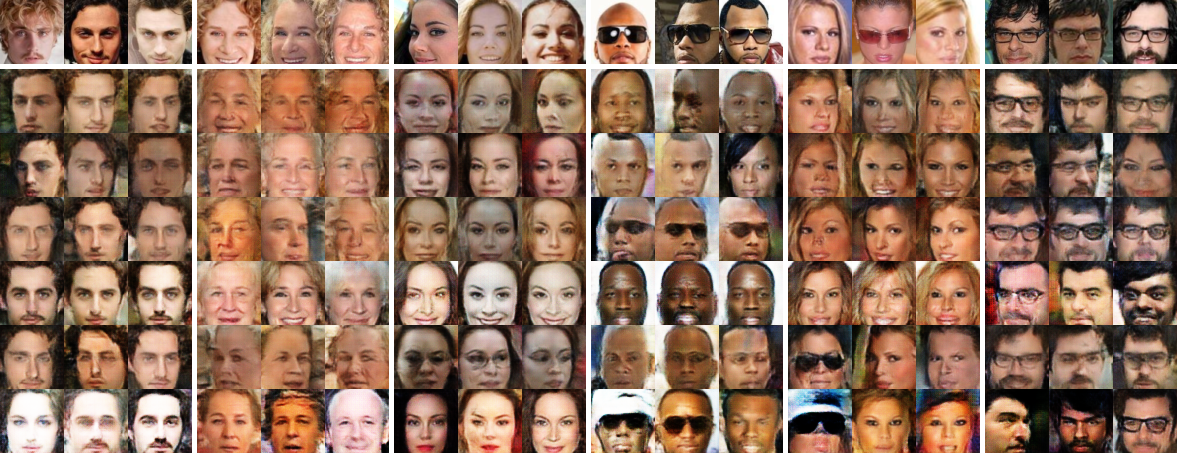

In [6]:
indices = [4, 291, 399, 678, 850, 951]
size = 64
margin = 5
m = 1 + len(raw_recovered)
n = min(len(indices), 6)
cnt = 3
# text_width = 95
text_width = 0
img = Image.new('RGB', size=(text_width + size*n*cnt + margin*(n-1), size*m + margin), color='white')

offset = 0

# Ground truth
for i, iden in enumerate(indices[:n]):
    gt_indices = torch.where(dataset.identity == iden)[0][:cnt]
    for j, idx in enumerate(gt_indices):
        img.paste(dataset[idx][0], (text_width + size*(i*cnt) + margin*i + size*j, offset))
offset += margin

for i, iden in enumerate(indices[:n]):
    for k, key in enumerate(['Unprotected', 'MID', 'BiDO', 'NegLS', 'Ours', 'Trap-MID + NegLS'], 1):
        syn_indices = torch.where(raw_recovered[key]['label'] == iden)[0][:cnt]
        for j, idx in enumerate(syn_indices):
            img.paste(transforms.ToPILImage()(raw_recovered[key]['imgs'][idx]), (text_width + size*(i*cnt) + margin*i + size*j, offset+size*k))

display(img)